## Flight Price Prediction (EDA + Feature Engineering)

In [11]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
import pickle
%matplotlib inline

In [12]:
# Load the dataset
try:
    train_df = pd.read_excel('Data_Train.xlsx')
    print("Dataset loaded successfully!")
    print(train_df.head())
except FileNotFoundError:
    print("Error: 'Data_Train.xlsx' not found. Please ensure the file is in the working directory.")

Dataset loaded successfully!
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  


In [13]:
# Create a copy to avoid modifying the original dataframe
final_df = train_df.copy()
print("Shape of the dataset:", final_df.shape)

Shape of the dataset: (10683, 11)


In [14]:
# Basic EDA
print("\nDataset Info:")
final_df.info()
print("\nMissing Values:")
print(final_df.isnull().sum())
print("\nUnique Airlines:")
print(final_df['Airline'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB

Missing Values:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price      

In [15]:
# Feature Engineering
# Handle missing values
final_df.dropna(inplace=True)  # Drop rows with missing values (Route, Total_Stops)

# Split Date_of_Journey
final_df['Date'] = final_df['Date_of_Journey'].str.split('/').str[0].astype(int)
final_df['Month'] = final_df['Date_of_Journey'].str.split('/').str[1].astype(int)
final_df['Year'] = final_df['Date_of_Journey'].str.split('/').str[2].astype(int)
final_df.drop('Date_of_Journey', axis=1, inplace=True)

# Convert Dep_Time and Arrival_Time to hours and minutes
final_df['Dep_hour'] = pd.to_datetime(final_df['Dep_Time'], format='%H:%M').dt.hour
final_df['Dep_min'] = pd.to_datetime(final_df['Dep_Time'], format='%H:%M').dt.minute
final_df.drop('Dep_Time', axis=1, inplace=True)

# Arrival_Time may include date, so we split it
final_df['Arrival_Time'] = final_df['Arrival_Time'].str.split(' ').str[0]
final_df['Arrival_hour'] = pd.to_datetime(final_df['Arrival_Time'], format='%H:%M').dt.hour
final_df['Arrival_min'] = pd.to_datetime(final_df['Arrival_Time'], format='%H:%M').dt.minute
final_df.drop('Arrival_Time', axis=1, inplace=True)

# Convert Duration to total minutes
def duration_to_minutes(duration):
    hours, minutes = 0, 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
        duration = duration.split('h')[1]
    if 'm' in duration:
        minutes = int(duration.split('m')[0])
    return hours * 60 + minutes

final_df['Duration_minutes'] = final_df['Duration'].apply(duration_to_minutes)
final_df.drop('Duration', axis=1, inplace=True)

# Encode Total_Stops
final_df['Total_Stops'] = final_df['Total_Stops'].map({
    'non-stop': 0,
    '1 stop': 1,
    '2 stops': 2,
    '3 stops': 3,
    '4 stops': 4
})

# Drop Route (too granular, Total_Stops captures similar info)
final_df.drop('Route', axis=1, inplace=True)

# Encode categorical variables
final_df = pd.get_dummies(final_df, columns=['Airline', 'Source', 'Destination', 'Additional_Info'], drop_first=True)

print("\nProcessed Dataframe Head:")
print(final_df.head())


Processed Dataframe Head:
   Total_Stops  Price  Date  Month  Year  Dep_hour  Dep_min  Arrival_hour  \
0            0   3897    24      3  2019        22       20             1   
1            2   7662     1      5  2019         5       50            13   
2            2  13882     9      6  2019         9       25             4   
3            1   6218    12      5  2019        18        5            23   
4            1  13302     1      3  2019        16       50            21   

   Arrival_min  Duration_minutes  ...  Destination_New Delhi  \
0           10               170  ...                   True   
1           15               445  ...                  False   
2           25              1140  ...                  False   
3           30               325  ...                  False   
4           35               285  ...                   True   

   Additional_Info_1 Short layover  Additional_Info_2 Long layover  \
0                            False                     

In [16]:
# Prepare features and target
X = final_df.drop('Price', axis=1)
y = final_df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = r2_score(y_test, y_pred)
print(f"R² Score: {accuracy:.4f}")

R² Score: 0.9144


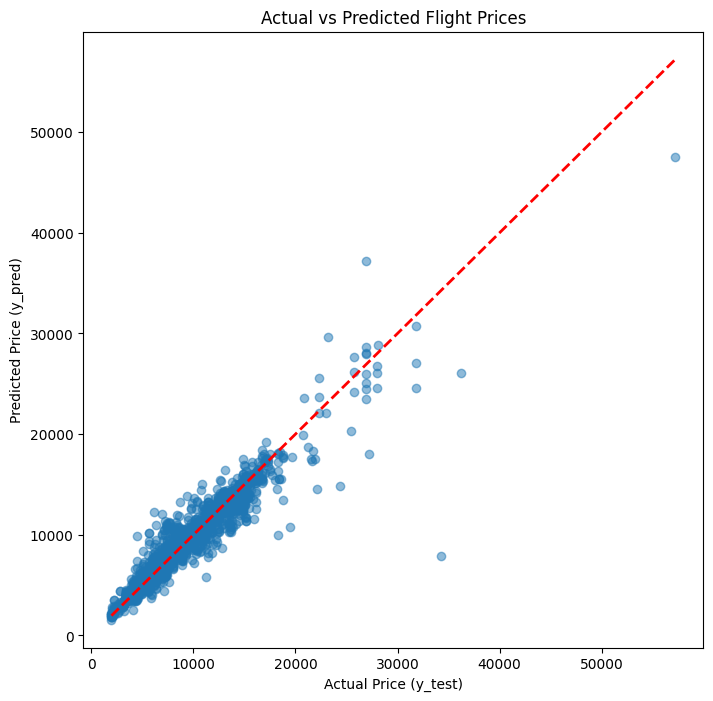

In [17]:
# Visualization of predictions
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Price (y_test)")
plt.ylabel("Predicted Price (y_pred)")
plt.title("Actual vs Predicted Flight Prices")
plt.show()

In [18]:
# Save the model
filename = 'flight_price_prediction.sav'
with open(filename, 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"Model saved to {filename}")

Model saved to flight_price_prediction.sav


In [19]:
# Load and test the saved model
with open('flight_price_prediction.sav', 'rb') as f:
    loaded_model = pickle.load(f)
print("Loaded Model:", loaded_model)

predictions = loaded_model.predict(X_test)
print("Sample Predictions:", predictions[:5])

Loaded Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)
Sample Predictions: [16907.37   5497.258  8522.15   3956.175 12161.989]


In [20]:
# Save model columns for future reference
model_columns = list(X_train.columns)
with open('model_columns.pkl', 'wb') as f:
    pickle.dump(model_columns, f)
print("Model columns saved successfully!")
print("Columns used in training:", model_columns)

Model columns saved successfully!
Columns used in training: ['Total_Stops', 'Date', 'Month', 'Year', 'Dep_hour', 'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_minutes', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business', 'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata', 'Destination_New Delhi', 'Additional_Info_1 Short layover', 'Additional_Info_2 Long layover', 'Additional_Info_Business class', 'Additional_Info_Change airports', 'Additional_Info_In-flight meal not included', 'Additional_Info_No Info', 'Additional_Info_No check-in baggage included', 'Additional_Info_No info', 'Additional_Info_Red-eye flight']
